In [338]:
from __future__ import print_function

import time
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.applications import vgg19
from keras.models import Model

# Set backend as tensorflow
from keras import backend as K
K.set_image_dim_ordering("tf")

from scipy.optimize import fmin_l_bfgs_b

from PIL import Image

%matplotlib inline

In [339]:
import h5py

f = h5py.File("vgg19_weights_tf_dim_ordering_tf_kernels.h5", "r")
print(f.keys())

[u'block1_conv1', u'block1_conv2', u'block1_pool', u'block2_conv1', u'block2_conv2', u'block2_pool', u'block3_conv1', u'block3_conv2', u'block3_conv3', u'block3_conv4', u'block3_pool', u'block4_conv1', u'block4_conv2', u'block4_conv3', u'block4_conv4', u'block4_pool', u'block5_conv1', u'block5_conv2', u'block5_conv3', u'block5_conv4', u'block5_pool', u'fc1', u'fc2', u'flatten', u'predictions']


In [340]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
#     ('block1_conv2', 0.2),
#     ('block2_conv1', 0.2),
    ('block2_conv2', 0.2),
#     ('block3_conv1', 0.2),
#     ('block3_conv2', 0.2),
#     ('block3_conv3', 0.2),
    ('block3_conv4', 0.2),
#     ('block4_conv1', 0.2),
#     ('block4_conv2', 0.2),
#     ('block4_conv3', 0.2),
    ('block4_conv4', 0.2),
#     ('block5_conv1', 0.2),
#     ('block5_conv2', 0.2),
#     ('block5_conv3', 0.2),
    ('block5_conv4', 0.2)]

In [341]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    CONTENT_WEIGHT = 0.025
    STYLE_WEIGHT = 5.0
    TOTAL_VARIATION_WEIGHT = 1.0
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [342]:
def reshape_and_normalize_image(image_path):
    """
    Reshape and normalize the input image (content or style)
    """
    
    image = Image.open(image_path)
    image = image.resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT))
    
    image_array = np.asarray(image, dtype='float32')
    image = np.expand_dims(image_array, axis=0)
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image

In [343]:
# Get content_image from file
content_image_path = "./images/monet.jpg"
content_image = reshape_and_normalize_image(content_image_path)
content_image = K.variable(content_image)

In [344]:
style_image_path = "./images/louvre_small.jpg"
style_image = reshape_and_normalize_image(style_image_path)
style_image = K.variable(style_image)

In [345]:
generated_image = K.placeholder((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, 3))

In [346]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([content_image,
                              style_image,
                              generated_image], axis=0)

In [347]:
model = vgg19.VGG19(input_tensor=input_tensor, weights=None, include_top=True)
model.load_weights("vgg19_weights_tf_dim_ordering_tf_kernels.h5")

In [348]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [349]:
def content_loss(content, generated):
    return K.sum(K.square(generated - content))

In [350]:
# loss for content image
loss = K.variable(0.)
layer_features = outputs_dict['block2_conv2']
content_features = layer_features[0, :, :, :]
generated_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(content_features, generated_features)

In [351]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, generated):
    assert K.ndim(style) == 3
    assert K.ndim(generated) == 3
    S = gram_matrix(style)
    C = gram_matrix(generated)
    channels = CONFIG.COLOR_CHANNELS
    size = CONFIG.IMAGE_HEIGHT * CONFIG.IMAGE_WIDTH
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [352]:
# loss for style image
for layer_name, coeff in STYLE_LAYERS:
    layer_features = outputs_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    generated_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, generated_features)
    loss += (coeff / len(feature_layers)) * sl

In [353]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    img_nrows = CONFIG.IMAGE_HEIGHT
    img_ncols = CONFIG.IMAGE_WIDTH
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [354]:
loss += CONFIG.TOTAL_VARIATION_WEIGHT * total_variation_loss(generated_image)

In [355]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, generated_image)

In [356]:
outputs = [loss]
outputs += grads
f_outputs = K.function([generated_image], outputs)

In [357]:
def eval_loss_and_grads(x):
    x = x.reshape((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [358]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(loss)

In [362]:
x = np.random.uniform(0, 255, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, 3)) - 128.

image = K.variable(x)

model(image)

# iterations = 10

# evaluator = Evaluator()

# for i in range(iterations):
#     print('Start of iteration', i)
#     start_time = time.time()
#     x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=1)
#     print('Current loss value:', min_val)
#     end_time = time.time()
#     print('Iteration %d completed in %ds' % (i, end_time - start_time))

<tf.Tensor 'vgg19_1/predictions/Softmax:0' shape=(?, 1000) dtype=float32>

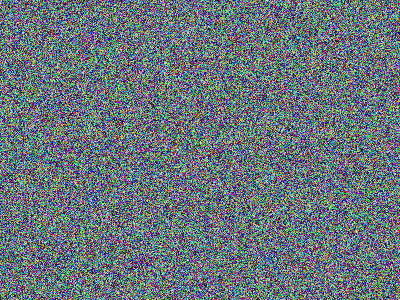

In [330]:
x = x.reshape((CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)